### MINST classification

In [28]:
#import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [29]:
#print(tf.config.list_physical_devices('GPU'))
import torch
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

[]

#### Loading the MNIST dataset

In [30]:
def prepare_data(ds):

    #data prep
    #ds = tfds.load('mnist', split='train')

    #train_ds = train_ds.map(lambda feature_dict: feature_dict['image'], feature=['label'])
    ds = ds.map(lambda image, label: (tf.reshape(image,(-1,)), label))
    ds = ds.map(lambda image, label: ((tf.cast(image,tf.float32)/128)-1, label))
    ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth= 10)))
    ds = ds.shuffle(1024).batch(128)
    ds = ds.prefetch(4)

    # for x,y in ds.take(1):
    #     print(x,y)

    return ds

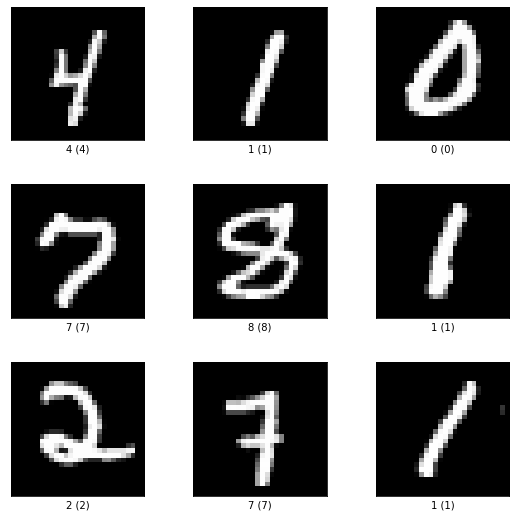

In [31]:
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train','test'],as_supervised=True, with_info=True)

tfds.show_examples(train_ds, ds_info)

train_ds = prepare_data(train_ds)
test_ds = prepare_data(test_ds)

### Building a deep neural network

In [32]:
#Model Creation via Subclassing from tf.keras.Model
class MLP_Model(tf.keras.Model):
    def __init__ (self, layer_sizes, output_size=10):
        super().__init__()
        self.mlp_layers = []
        #layer_sizes e. g. [256,256]
        for layer_size in layer_sizes:
            new_layer = tf.keras.layers.Dense(units = layer_size, activation='sigmoid')
            self.mlp_layers.append(new_layer)
        self.output_layer = tf.keras.layers.Dense(units = output_size, activation='softmax')

    def call(self, x):
        for layer in self.mlp_layers:
            x = layer(x)
        return self.output_layer(x)


### Training the network

In [33]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        pred = model.call(x)
        loss = loss_func(target, pred)

    gradients = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(gradients, model.variables))
    return loss.numpy()

def test(model, test_data, loss_function):
    # test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        test_loss_aggregator.append(np.mean(sample_test_loss))
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy


In [34]:
def training(epochs, model, training_ds, test_ds, loss_func, optimizer):
    epoch_losses = []
    epoch_test_loss= []
    epoch_test_accuracies = []
    for epoch in range( epochs):
        losses = []
        for x, target in training_ds:
            with tf.GradientTape() as tape:
                pred = model.call(x)
                loss = loss_func(target, pred)

            gradients = tape.gradient(loss, model.variables)
            optimizer.apply_gradients(zip(gradients, model.variables))
            losses.append(loss.numpy())
        epoch_losses.append(tf.reduce_mean(losses))

        test_loss, test_accuracy = test (model, test_ds, loss_func)
        epoch_test_loss.append(test_loss)
        epoch_test_accuracies.append(test_accuracy)
    return epoch_losses, epoch_test_loss, epoch_test_accuracies

    

### Visualisation

In [35]:
plotting = {}

In [36]:
# 1. Model
tf.keras.backend.clear_session()
epochs = 10
model = MLP_Model(layer_sizes=(256,256))
cce = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.02)

train_losses, test_losses, test_accuracies = training(epochs=epochs, model=model,training_ds=train_ds,test_ds=test_ds, loss_func=cce, optimizer=optimizer)
plotting["basic"] = [train_losses, test_losses, test_accuracies]

In [37]:
# 2. Model other optimizer
tf.keras.backend.clear_session()
epochs = 10
model = MLP_Model(layer_sizes=(256,256))
cce = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.02)

train_losses, test_losses, test_accuracies = training(epochs=epochs, model=model,training_ds=train_ds,test_ds=test_ds, loss_func=cce, optimizer=optimizer)
plotting["adam optimizer"] = [train_losses, test_losses, test_accuracies]

In [38]:
# 3. more epochs
tf.keras.backend.clear_session()
epochs = 30
model = MLP_Model(layer_sizes=(256,256))
cce = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.02)

train_losses, test_losses, test_accuracies = training(epochs=epochs, model=model,training_ds=train_ds,test_ds=test_ds, loss_func=cce, optimizer=optimizer)
plotting["more epochs"] = [train_losses, test_losses, test_accuracies]

In [39]:
# 4. higher learning rate
tf.keras.backend.clear_session()
epochs = 10
model = MLP_Model(layer_sizes=(256,256))
cce = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.04)

train_losses, test_losses, test_accuracies = training(epochs=epochs, model=model,training_ds=train_ds,test_ds=test_ds, loss_func=cce, optimizer=optimizer)
plotting["higher learningrate"] = [train_losses, test_losses, test_accuracies]

In [40]:
# 5. more layers
tf.keras.backend.clear_session()
epochs = 20
model = MLP_Model(layer_sizes=(256,256,128))
cce = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.02)

train_losses, test_losses, test_accuracies = training(epochs=epochs, model=model,training_ds=train_ds,test_ds=test_ds, loss_func=cce, optimizer=optimizer)
plotting["more layers"] = [train_losses, test_losses, test_accuracies]

In [41]:
# 6. viewer units per layer
tf.keras.backend.clear_session()
epochs = 10
model = MLP_Model(layer_sizes=(128,128))
cce = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.02)

train_losses, test_losses, test_accuracies = training(epochs=epochs, model=model,training_ds=train_ds,test_ds=test_ds, loss_func=cce, optimizer=optimizer)
plotting["fewer units"] = [train_losses, test_losses, test_accuracies]

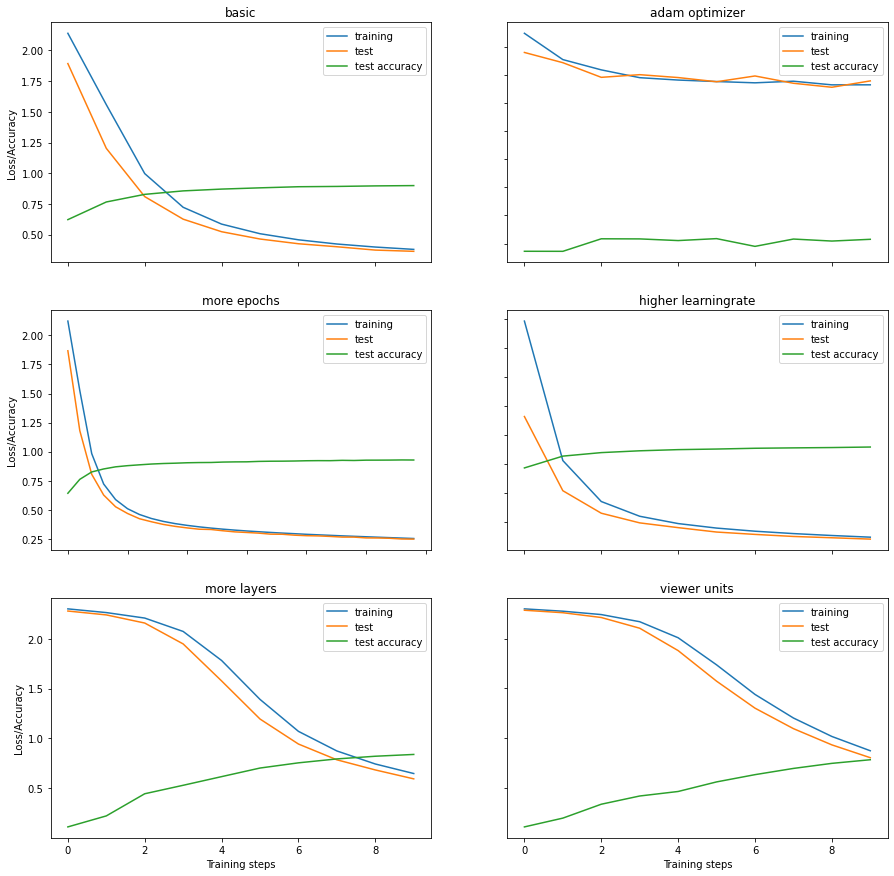

In [42]:
# plotting
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
for ax, key in zip(axs.flat, plotting.keys()):
    
    train_losses, test_losses, test_accuracies = plotting[key]
    
    line1, = ax.plot(train_losses)
    line2, = ax.plot(test_losses)
    line3, = ax.plot(test_accuracies)
    ax.legend((line1,line2, line3),("training","test", "test accuracy"))
    ax.set_title(key)
    ax.set(xlabel="Training steps", ylabel="Loss/Accuracy")
    ax.label_outer()
    
plt.show()